In [1]:
# Luís 22/11/2022

# This example was taken and adapted from https://doi.org/10.48550/arXiv.2210.09060

# I followed the original code, with some minor modifications to make it more readable
# and organized it as a Jupyter Notebook.

# Still need to understand better:

# Mechanics: definition fo the loss functions
# Python code: "with" statements; @tf.function
# Implementation: Dif and L_BFGS_B classes; tf.GradientTape (for "automatic differentiation")

# Notes

# I believe I could implement my own optimizer, from the knowledge gathered in the Optimization
# of Mechanical Systems class. It would of course be probably way less efficient than the Scipy optimizer, though.

# I will keep exploring the implementation of this code by doing a similar analisys on the
# 2D and 3D examples, so that I can later extrapolate and implement on a case of interest of mine.

# 1D Beam under traction solved using a PINN

In [2]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import numpy as np
import scipy.optimize

import time
import matplotlib.pyplot as plt
import scipy.io

## Load the problem information, including:
    1. Definition of the problem geometry;
    2. Definition of the material property;
    3. Definition of the boundary condition;
    4. Definition of the FNN settings.
    
### Variables:

**[ns]**;        [int]                   : Total number of sample points;

**[dx]**;        [float]                 : Sample points interval;

**[xy]**;        [Array of float32]      : Coordinates of all the sample points;

**[xy_r]**;      [Array of float32]      : Coordinates of the sample points on the right tip of the rod;

**[x_train]**;   [List]                  : PINN input list, contains all the coordinates information;

**[s_r_x]**;     [Array of float32]      : Traction boundary condition on the right tip of the rod;

**[y_train]**;   [List]                  : PINN boundary condition list, contains the traction boundary condition;

**[n_input]**;   [int]                   : Number of inputs for the FNN;

**[n_output]**;  [int]                   : Number of outputs for the FNN;

**[layers]**;    [list]                  : Size of the FNN;

**[acti_fun]**;  [str]                   : The activation function used after each layer;
                                                    Available options:
                                                    'tanh'
                                                    'sigmoid'
                                                    'relu'
                                                        ... (more details in https://keras.io/api/layers/activations/)
                                                        
**[k_init]**;    [str]                   : The kernel initialisation method;

**[NN_info]**;   [list]                  : Neural Network information list, contains the settings for the FNN;

**[E]**;         [float]                 : Young's module.

In [4]:
### Define the number of sample points
ns = 51
    
### Define the sample points' interval
dx = 1./(ns-1)
    
### Initialize sample points' coordinates
xy = np.reshape(np.linspace(0,(ns-1)*dx,num = ns), [51,1]).astype(np.float32)
xy_r = np.array([1.])
    
### Create the PINN input list
x_train = [xy, xy_r]

print("Vector with all points has shape:", np.shape(xy))
print("Vector with points subjected to the traction BC has shape:", np.shape(xy_r))

Vector with all points has shape: (51, 1)
Vector with points subjected to the traction BC has shape: (1,)


In [5]:
### Define the Young's modulus
E = 10.
    
### Define the traction boundary condition at the right tip of the rod
s_r_x = 1.
    
### Create the PINN boundary condition list
y_train = [s_r_x]

print("Young's Modulus:", E)
print("PINN traction BC value (as a list):", y_train)

Young's Modulus: 10.0
PINN traction BC value (as a list): [1.0]


In [6]:
### Define the FNN settings
n_input = 1
n_output = 1
layers = np.array([5, 5, 5]) # 3 hidden layers with 5 nodes each
acti_fun = 'tanh'
k_init = 'LecunNormal'
NN_info = [n_input, n_output, layers, acti_fun, k_init]

print('NN_info =', NN_info)

NN_info = [1, 1, array([5, 5, 5]), 'tanh', 'LecunNormal']


In [7]:
### Visualise the summary of the problem setup
print('*************************************************')
print('Problem Info.')
print('*************************************************\n')
print(ns, 'sample points')
print('The Young''s module is', E,' Pa.\n')
print('*************************************************')
print('Neural Network Info.')
print('*************************************************\n')
print('net_u \nNumber of input:',n_input,', Number of output:',n_output,'.')
print(len(layers),'hidden layers,',layers[0],' neurons per layer.\n')
print('*************************************************\n')

*************************************************
Problem Info.
*************************************************

51 sample points
The Youngs module is 10.0  Pa.

*************************************************
Neural Network Info.
*************************************************

net_u 
Number of input: 1 , Number of output: 1 .
3 hidden layers, 5  neurons per layer.

*************************************************



## Initialise a FNN

### Variables:

**[n_input]**; [int]: Number of inputs for the FNN;

**[n_output]**; [int]: Number of outputs for the FNN;

**[layers]**; [list]: Size of the FNN;

**[acti_fun]**; [str]: The activation function used after each layer;
                                                        Available options:
                                                        'tanh'
                                                        'sigmoid'
                                                        'relu'
                                                        ... (more details in https://keras.io/api/layers/activations/)
                                                        
**[k_init]**; [str]: The kernel initialisation method;

**[x]**; [Keras layer]: Input of the FNN;

**[temp]**; [Keras layer]: Hidden layers of the FNN;

**[y]**; [Keras layer]: Output of the FNN;

**[net]**; [Keras model]: The built FNN.

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 5)                 10        
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 30        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6         
Total params: 76
Trainable params: 76
Non-trainable params: 0
_________________________________________________________________


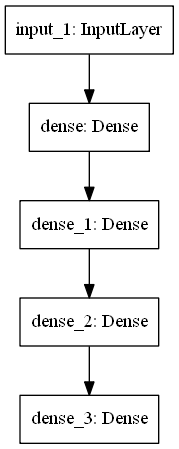

In [8]:
### Setup the input layer of the FNN
x = tf.keras.layers.Input(shape=(n_input))
    
### Setup the hidden layers of the FNN
temp = x
for l in layers:
    temp = tf.keras.layers.Dense(l, activation = acti_fun, kernel_initializer=k_init)(temp)
    
### Setup the output layers of the FNN
y = tf.keras.layers.Dense(n_output, kernel_initializer=k_init)(temp)

### Combine the input, hidden, and output layers to build up a FNN
net = tf.keras.models.Model(inputs=x, outputs=y)

net.summary()

tf.keras.utils.plot_model(net)

In [9]:
class Dif(tf.keras.layers.Layer):
    """
    ====================================================================================================================

    This is the class for calculating the differential terms of the FNN's output with respect to the FNN's input. We
    adopt the GradientTape function provided by the TensorFlow library to do the automatic differentiation.
    This class include 2 functions, including:
        1. __init__()         : Initialise the parameters for differential operator;
        2. call()             : Calculate the differential terms.

    ====================================================================================================================
    """

    def __init__(self, fnn, **kwargs):
        """
        ================================================================================================================

        This function is to initialise for differential operator.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [fnn]       [Keras model]           : The Feedforward Neural Network.
        
        ================================================================================================================
        """
        self.fnn = fnn
        super().__init__(**kwargs)

    def call(self, x):
        """
        ================================================================================================================

        This function is to calculate the differential terms.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [x]         [Keras model]           : The coordinate array;
        [temp]      [Keras tensor]          : The intermediate output from the FNN;
        [u]         [Keras tensor]          : The displacement predictions;
        [u_x]       [Keras tensor]          : The first-order derivative of the u with respect to the x;
        [u_xx]      [Keras tensor]          : The second-order derivative of the u with respect to the x.

        ================================================================================================================
        """

        ### Apply the GradientTape function
        with tf.GradientTape(persistent=True) as gg:
            gg.watch(x)
            with tf.GradientTape(persistent=True) as g:
                g.watch(x)

                ### Obtain the intermediate output from the FNN
                temp = self.fnn(x)

                ### Calculate the displacement output by times the coordinate to naturally satisfy the displacement
                ### boundary condition
                u = temp * x

            ### Obtain the first-order derivative of the output with respect to the input
            u_x = g.gradient(u, x)
            del g

        ### Obtain the second-order derivative of the output with respect to the input
        u_xx = gg.gradient(u_x, x)
        del gg

        return u_x, u_xx

In [10]:
def Material(U_x, U_xx, E):
    """
    ====================================================================================================================

    This function is to calculate the strain and stress based on the constitutive equation.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [U_x]       [Keras tensor]          : First-order derivative of displacement with respect to x direction;
    [U_xx]      [Keras tensor]          : Second-order derivative of displacement with respect to x direction;
    [epsilon]   [Keras tensor]          : Strain;
    [sigma]     [Keras tensor]          : Stress;
    [Ge]        [Keras tensor]          : Residual from the equilibrium equation;
    [E]         [float]                 : Young's module.

    ====================================================================================================================
    """

    ### Calculate strain
    epsilon = U_x

    ### Calculate stress
    sigma = E * epsilon

    ### Calculate the residual from equilibrium equation
    Ge = E * U_xx

    return epsilon, sigma, Ge


In [11]:
net_u = net

"""
====================================================================================================================

Initialize a PINN.

--------------------------------------------------------------------------------------------------------------------

Name        Type                    Info.

[net_u]     [keras model]           : The trained FNN for displacement u;
[xy]        [Keras input layer]     : Coordinates of all the sample points;
[xy_r]      [Keras input layer]     : Coordinate of the sample point at the right tip of the rod;
[U_r]       [Keras tensor]          : Displacement at the right tip of the rod;
[U_x]       [Keras tensor]          : First-order derivative of displacement with respect to x direction;
[U_xx]      [Keras tensor]          : Second-order derivative of displacement with respect to x direction;
[U_r_x]     [Keras tensor]          : First-order derivative of displacement at the right tip of the rod with
                                          respect to x direction;
[U_r_xx]    [Keras tensor]          : Second-order derivative of displacement at the right tip of the rod with
                                          respect to x direction;
[epsilon]   [Keras tensor]          : Strain;
[sigma]     [Keras tensor]          : Stress;
[Ge]        [Keras tensor]          : Residual from the equilibrium equation;
[sigma_r]   [Keras tensor]          : Stress at the right tip of the rod;
 [E]         [float]                 : Young's module.

====================================================================================================================
"""

### declare PINN's inputs
xy = tf.keras.layers.Input(shape=(1,))
xy_r = tf.keras.layers.Input(shape=(1,))
    
### initialize the differential operators
Dif_u = Dif(net_u)
    
### obtain the displacment at the right tip of the rod
u_r = net_u(xy_r) * xy_r
    
### obtain partial derivatives of u with respect to x
u_x, u_xx = Dif_u(xy)
u_r_x, u_r_xx = Dif_u(xy_r)
       
### obtain the residuals from the governing equation and traction boundary condition
epsilon, sigma, Ge = Material(u_x, u_xx, E)
_, sigma_r, _ = Material(u_r_x, u_r_xx, E)
    
### build up the PINN
pinn = tf.keras.models.Model(inputs=[xy, xy_r], outputs=[Ge, sigma_r, sigma, epsilon, u_r])

In [12]:
pinn.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dif (Dif)                       ((None, 1), (None, 1 76          input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
model (Functional)              (None, 1)            76          input_3[0][0]              

In [13]:
def Collocation_Loss(y_p, y):
    """
    ====================================================================================================================

    Collocation loss function

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [y_p]       [list]                  : Outputs from the PINN;
    [y]         [list]                  : The ground truth data;
    [l1]        [Keras tensor]          : The loss term from the equilibrium equation;
    [l2]        [Keras tensor]          : The loss term from the traction boundary condition;
    [loss]      [Keras tensor]          : The final loss

    ====================================================================================================================
    """

    ### Residual from the governing equation
    l1 = tf.reduce_mean(tf.square(y_p[0])) # y_p[0] corresponds to Ge

    ### Residual from the traction boundary condition
    l2 = tf.reduce_mean(tf.square(y_p[1]-y[0])) # y_p[1] corresponds to sigma_r

    ### Final loss
    loss = l1 + l2

    return loss, l1, l2
    
def Energy_Loss(y_p, y, dx):
    """
    ====================================================================================================================

    Energy-based loss function

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [y_p]       [list]                  : Outputs from the PINN;
    [y]         [list]                  : The ground truth data;
    [dx]        [float]                 : Sample points interval;
    [l1]        [Keras tensor]          : The internal potential energy;
    [l2]        [Keras tensor]          : The potential energy of the external traction force;
    [loss]      [Keras tensor]          : The final loss

    ====================================================================================================================
    """

    ### Internal potential energy
    l1 = 0.5 * dx * tf.reduce_sum(y_p[2] * y_p[3])
    ### Potential energy of the external force
    l2 = tf.reduce_sum(y_p[4] * y[0])
    ### Final Loss
    loss = l1 - l2

    return loss, l1, l2

In [14]:
class L_BFGS_B:
    """
    ====================================================================================================================

    This is the class for the L-BFGS-B optimiser. We adopt core algorithm of the L-BFGS-B algorithm is provided by the
    Scipy library. This class include 5 functions, including:
        1. __init__()         : Initialise the parameters for the L-BFGS-B optimiser;
        2. pi_loss()          : Calculate the physics-informed loss;
        3. loss_grad()        : Obtain the gradients of the physics-informed loss with respect to the weighs and biases;
        4. set_weights()      : Set the modified weights and biases back to the neural network structure;
        5. fit()              : Execute training process.

    ====================================================================================================================
    """

    def __init__(self, pinn, x_train, y_train, dx, factr=10, pgtol=1e-10, m=50, maxls=50, maxfun=40000):
        """
        ================================================================================================================

        This function is to initialise the parameters used in the L-BFGS-B optimiser.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [dx]        [float]                 : Sample points interval;
        [factr]     [int]                   : The optimiser option. Please refer to SciPy;
        [pgtol]     [float]                 : The optimiser option. Please refer to SciPy;
        [m]         [int]                   : The optimiser option. Please refer to SciPy;
        [maxls]     [int]                   : The optimiser option. Please refer to SciPy;
        [maxfun]    [int]                   : Maximum number of iterations for training;
        [iter]      [int]                   : Number of training iterations;
        [his_l1]    [list of float32]       : History values of the l1 loss term;
        [his_l2]    [list of float32]       : History values of the l2 loss term.

        ================================================================================================================
        """

        ### Initialise the parameters
        self.pinn = pinn
        self.x_train = [ tf.constant(x, dtype=tf.float32) for x in x_train ]
        self.y_train = [ tf.constant(y, dtype=tf.float32) for y in y_train ]
        self.dx = dx
        self.factr = factr
        self.pgtol = pgtol
        self.m = m
        self.maxls = maxls
        self.maxfun = maxfun
        self.iter = 0
        self.his_l1 = []
        self.his_l2 = []

    def pi_loss(self, weights):
        """
        ================================================================================================================

        This function is to calculate the physics-informed loss.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [weights]   [list]                  : The weights and biases;
        [pinn]      [Keras tensor]          : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [loss]      [Keras tensor]          : Current value of the physics-informed loss;
        [l1]        [Keras tensor]          : The l1 loss term;
        [l2]        [Keras tensor]          : The l2 loss term;
        [grads]     [Keras tensor]          : The gradients of the physics-informed loss with respect to weights and
                                              biases;
        [iter]      [int]                   : Number of training iterations.

        ================================================================================================================
        """

        ### Update the weights and biases to the FNN
        self.set_weights(weights)

        ### Calculate the physics-informed loss and its gradients with respect to weights and biases
        loss, grads, l1, l2 = self.loss_grad(self.x_train, self.y_train)

        ### Count number of the training iteration
        self.iter = self.iter + 1

        ### Print the loss terms every 10 training iterations
        if self.iter % 10 == 0:
            print('Iter: %d   L1 = %.4g   L2 = %.4g' % (self.iter, l1.numpy(), l2.numpy()))

        ### Convert loss and grads from Keras tensor to ndarray
        loss = loss.numpy().astype('float64')
        grads = np.concatenate([g.numpy().flatten() for g in grads]).astype('float64')

        ### Save the current loss term in different np.array
        self.his_l1.append(l1)
        self.his_l2.append(l2)

        return loss, grads

    @tf.function
    def loss_grad(self, x_train, y_train):
        """
        ================================================================================================================

        This function is to obtain the gradients of the physics-informed loss with respect to the weighs and biases.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [x_train]   [list]                  : PINN input list, contains all the coordinates information;
        [y_train]   [list]                  : PINN boundary condition list, contains the traction boundary condition;
        [y_p]       [list]                  : List of predictions from the PINN;
        [loss]      [Keras tensor]          : Current value of the physics-informed loss;
        [l1]        [Keras tensor]          : The l1 loss term;
        [l2]        [Keras tensor]          : The l2 loss term;
        [dx]        [float]                 : Sample points interval;
        [grads]     [Keras tensor]          : The gradients of the physics-informed loss with respect to weights and
                                              biases.

        ================================================================================================================
        """

        with tf.GradientTape() as g:

            ### Predict outputs from the current PINN
            y_p = self.pinn(x_train)

            ### Apply the collocation loss function
            loss, l1, l2 = Collocation_Loss(y_p, y_train)

            ### Apply the energy-based loss function
            #loss, l1, l2 = Energy_Loss(y_p, y_train, self.dx)

        ### Obtain the gradients through automatic differentiation
        ### (GradientTape function provided by the TensorFlow)
        grads = g.gradient(loss, self.pinn.trainable_variables)

        return loss, grads, l1, l2

    def set_weights(self, weights):
        """
        ================================================================================================================

        This function is to Set the modified weights and biases back to the neural network structure.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [keras model]           : The Physics-informed neural network;
        [shapes]    [list]                  : The shapes of neural network's weights and biases;
        [weights]   [list]                  : The weights and biases.

        ================================================================================================================
        """

        ### Obtain the shapes of neural network's weights and biases
        shapes = [w.shape for w in self.pinn.get_weights()]

        ### Compute splitting indices
        split_ids = np.cumsum([np.prod(shape) for shape in [0] + shapes])

        ### Reshape the modified weights and biases to fit the neural network structure
        weights = [weights[from_id:to_id].reshape(shape)
                   for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes)]

        ### Set weights and biases to the neural network
        self.pinn.set_weights(weights)

        return None

    def fit(self):
        """
        ================================================================================================================

        This function is to execute training process.

        ----------------------------------------------------------------------------------------------------------------

        Name        Type                    Info.

        [pinn]      [Keras model]           : The Physics-informed neural network;
        [ini_w]     [ndarray]               : The initial weights and biases;
        [pi_loss]   [function]              : The function that calculates the physics-informed loss (line 61);
        [factr]     [int]                   : The optimiser option. Please refer to SciPy;
        [pgtol]     [float]                 : The optimiser option. Please refer to SciPy;
        [m]         [int]                   : The optimiser option. Please refer to SciPy;
        [maxls]     [int]                   : The optimiser option. Please refer to SciPy;
        [maxfun]    [int]                   : Maximum number of iterations for training;
        [result]    [tuple]                 : The result returned by the optimiser;
        [his_l1]    [list of float32]       : History values of the l1 loss term;
        [his_l2]    [list of float32]       : History values of the l2 loss term.

        ================================================================================================================
        """

        ### Get initial weights and biases
        ini_w = np.concatenate([ w.flatten() for w in self.pinn.get_weights() ])

        ### Optimise the weights and biases via the L-BFGS-B optimiser
        print('Optimizer: L-BFGS-B (Provided by Scipy package)')
        print('Initializing ...\n')
        result = scipy.optimize.fmin_l_bfgs_b(func=self.pi_loss, x0=ini_w,
            factr=self.factr, pgtol=self.pgtol, m=self.m, maxls=self.maxls, maxfun=self.maxfun)

        return result, [np.array(self.his_l1), np.array(self.his_l2)]

In [21]:
"""
    ====================================================================================================================

        1. Load the problem information;
        2. Build up the FNN;
        3. Build up the PINN;
        4. Initialize the L-BFGS-B optimiser.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [ns]        [int]                   : Total number of sample points;
    [ns_u]      [int]                   : Number of sample points on top boundary of the beam;
    [ns_l]      [int]                   : Number of sample points on left boundary of the beam;
    [dx]        [float]                 : Sample points interval;
    [x_train]   [List]                  : PINN input list, contains all the coordinates information;
    [y_train]   [List]                  : PINN boundary condition list, contains all the traction boundary conditions;
    [NN_info]   [list]                  : Neural Network information list, contains the settings for the FNN;
    [E]         [float]                 : Young's module;
    [net_u]     [Keras model]           : The built FNN;
    [pinn]      [Keras model]           : The built PINN;
    [l_bfgs_b]  [class]                 : The initialised L-BFGS-B optimiser.
        
    ====================================================================================================================
"""
    
### Initialize the L-BFGS-B optimizer
l_bfgs_b = L_BFGS_B(pinn, x_train, y_train, dx)

## Training the PINN using the BFGS optimizer

In [22]:
"""
====================================================================================================================

    Train the neural networks with the selected optimizer.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.

    [result]    [tuple]                 : The result returned by the optimiser;
    [his_loss]  [list]                  : History values of the loss terms;
    [t]         [float]                 : CPU time used for training;
    [l]         [float]                 : Final loss;
    [it]        [int]                   : The number of iterations for convergence.

    ====================================================================================================================
"""

### Execute the training process
time_start = time.time()
result, his_loss = l_bfgs_b.fit()
time_end = time.time()

### Record the training time
t = time_end-time_start

### Record the final loss
l = result[1]

### Record the number of iterations for convergence
it = result[2]['funcalls']

print('\n*************************************************\n')
print('Time cost is', t, 's')
print('Final loss is', l, '')
print('Training converges by', it, 'iterations\n')
print('*************************************************\n')

Optimizer: L-BFGS-B (Provided by Scipy package)
Initializing ...

Iter: 10   L1 = 0.06749   L2 = 0.0008923
Iter: 20   L1 = 0.0004517   L2 = 8.36e-08
Iter: 30   L1 = 0.0001288   L2 = 2.389e-09
Iter: 40   L1 = 5.532e-05   L2 = 4.086e-06
Iter: 50   L1 = 5.778e-07   L2 = 5.349e-09
Iter: 60   L1 = 4.63e-07   L2 = 3.553e-15
Iter: 70   L1 = 4.63e-07   L2 = 3.553e-15

*************************************************

Time cost is 1.355708360671997 s
Final loss is 4.6303506451295107e-07 
Training converges by 73 iterations

*************************************************



## Post-Processing

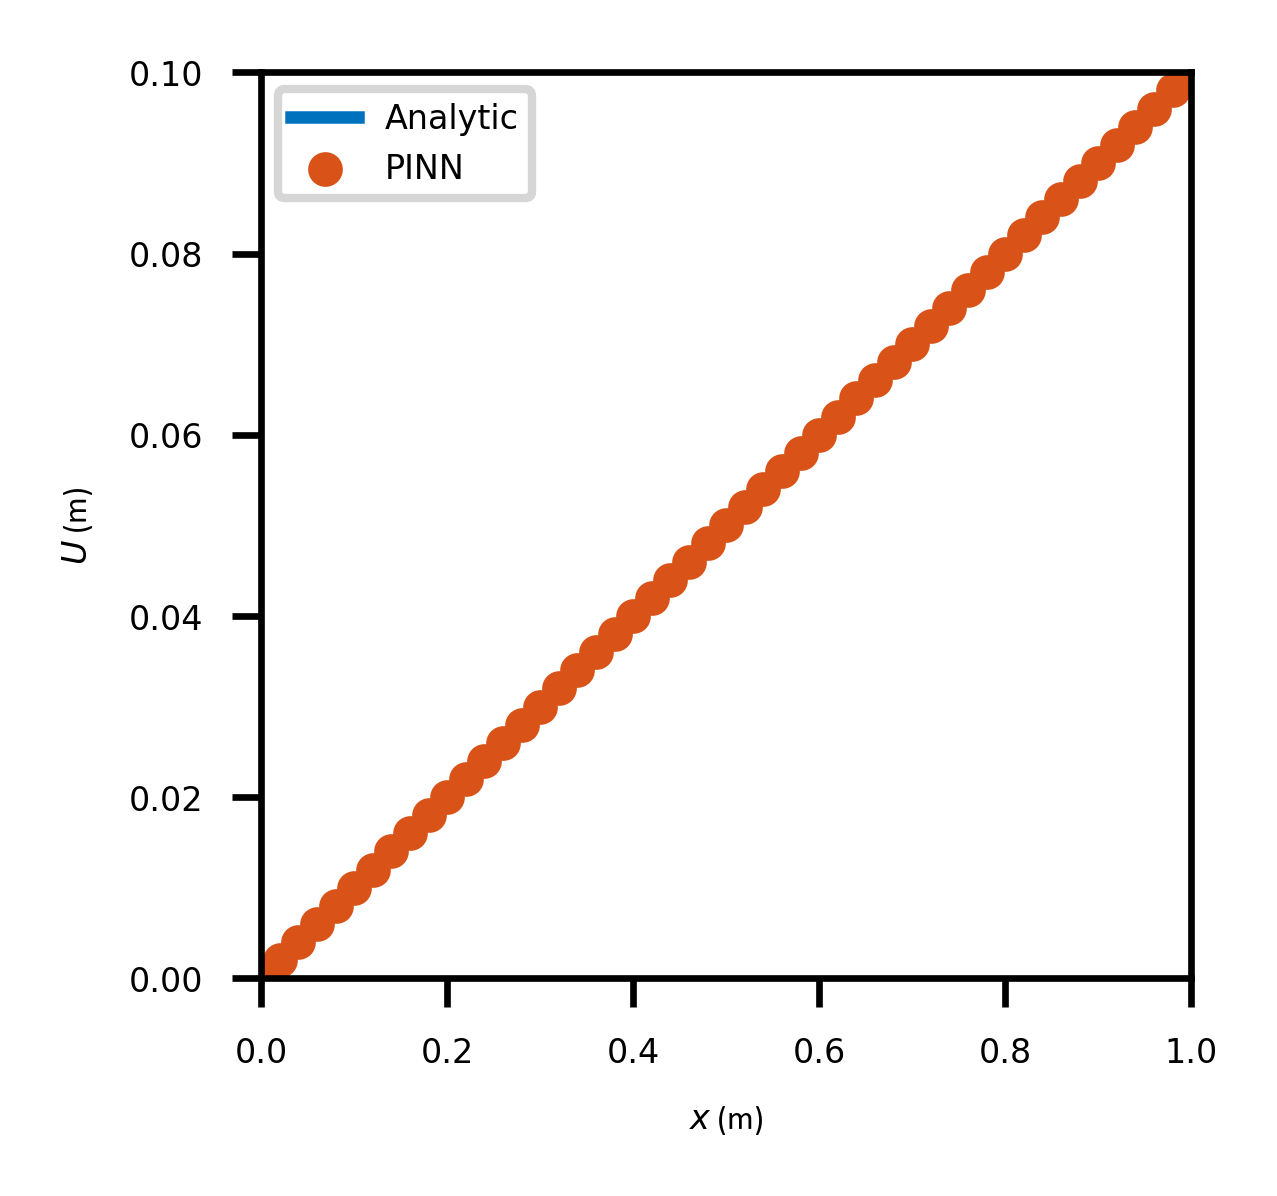

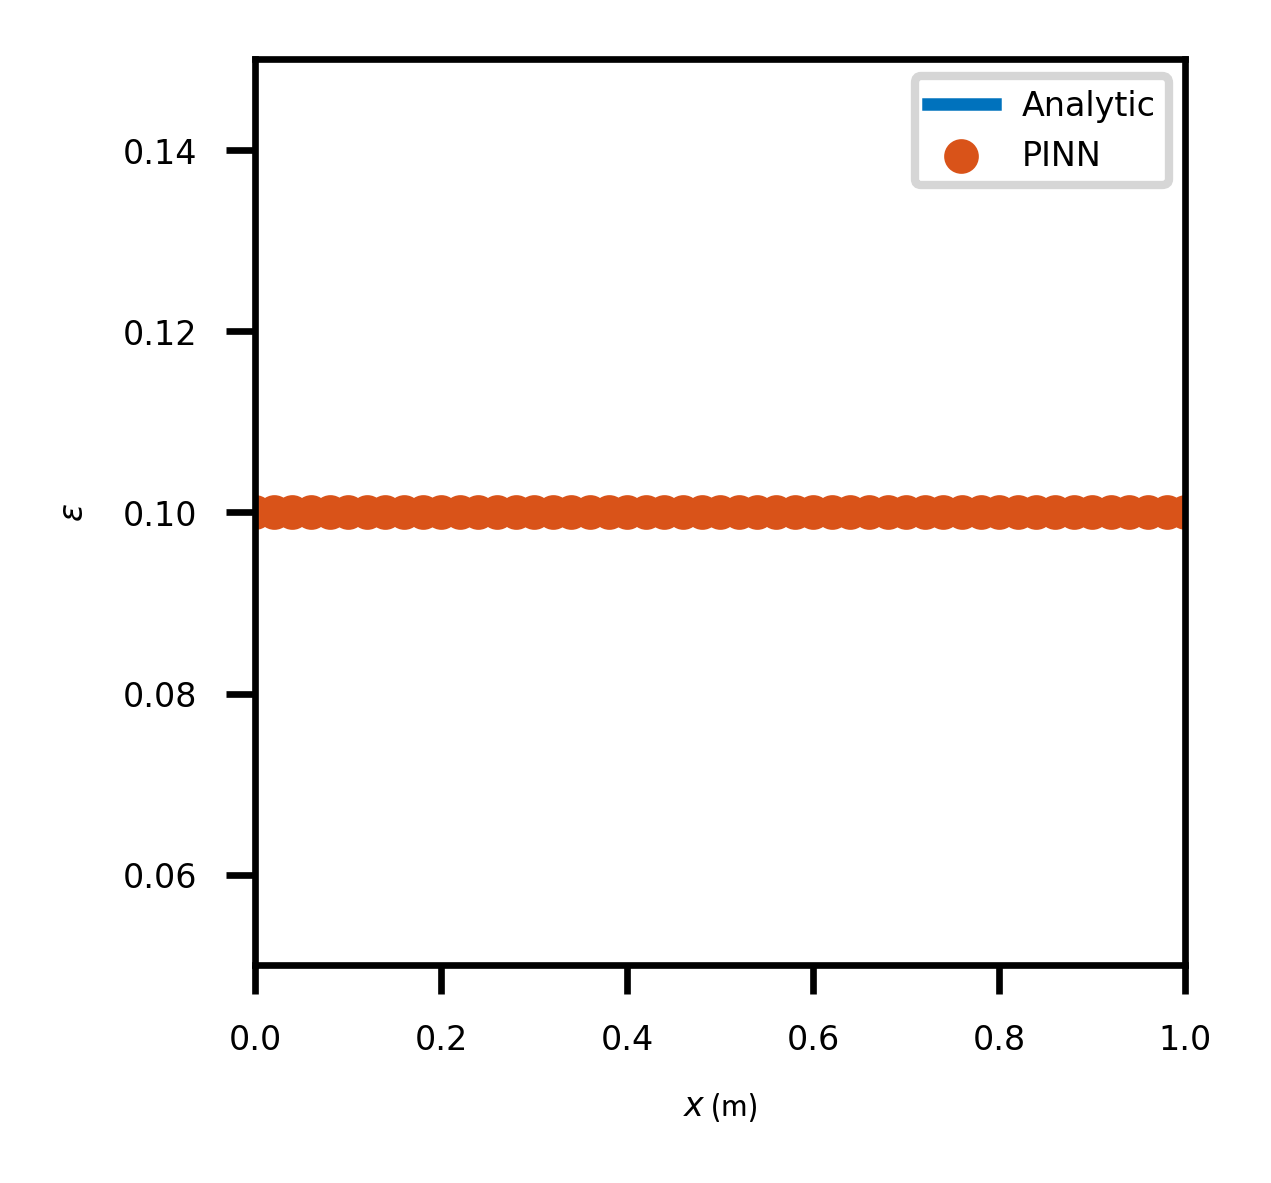

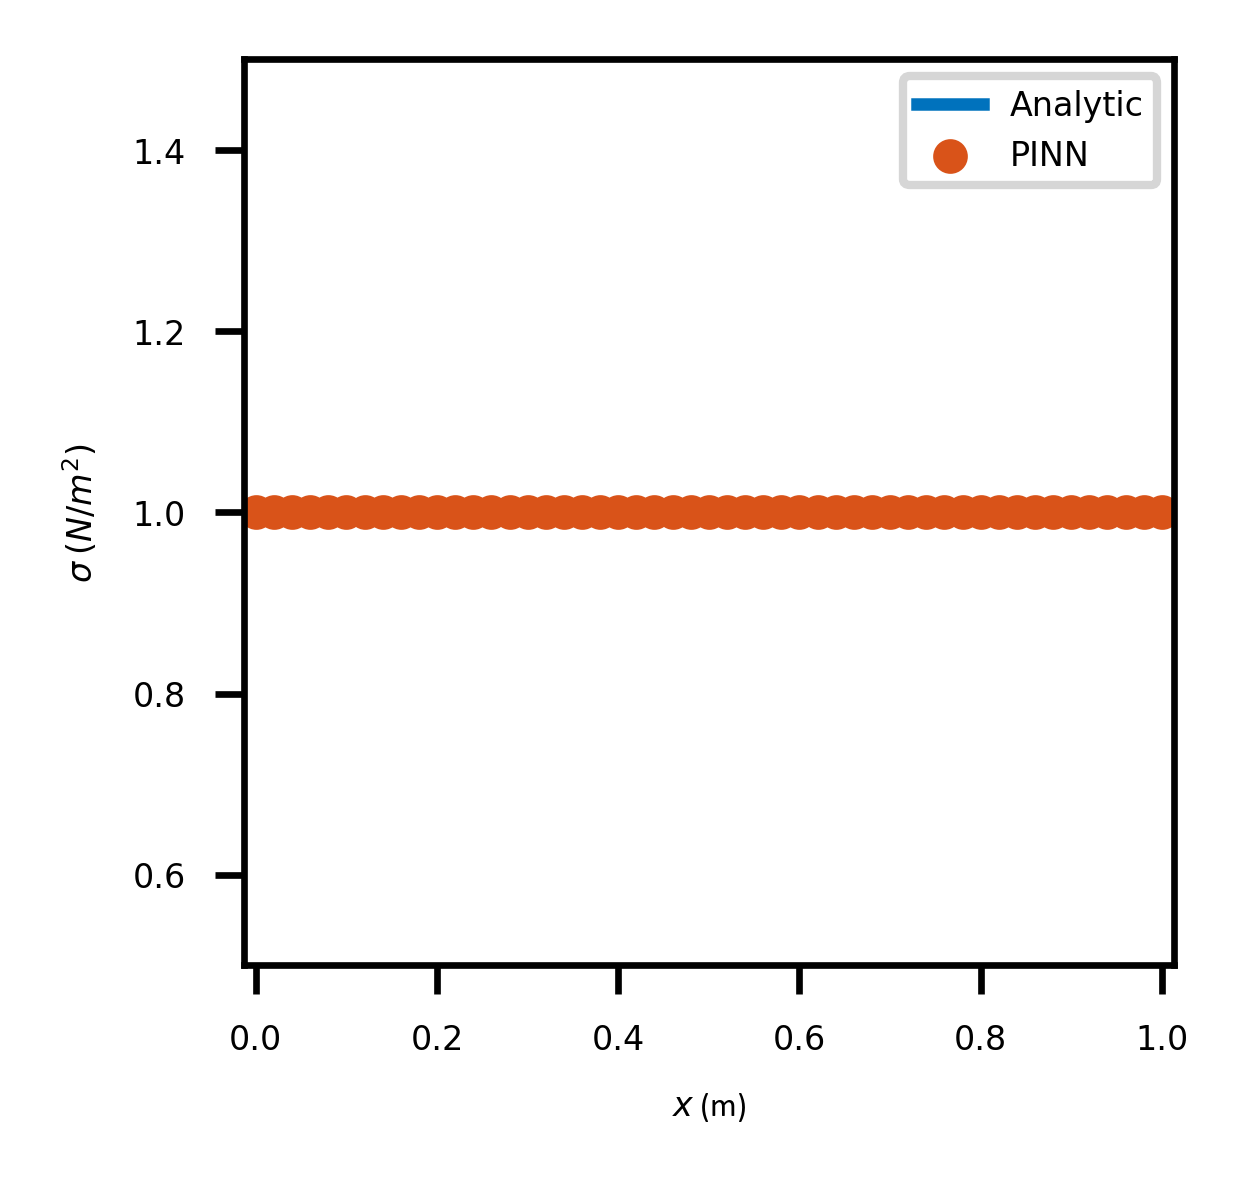

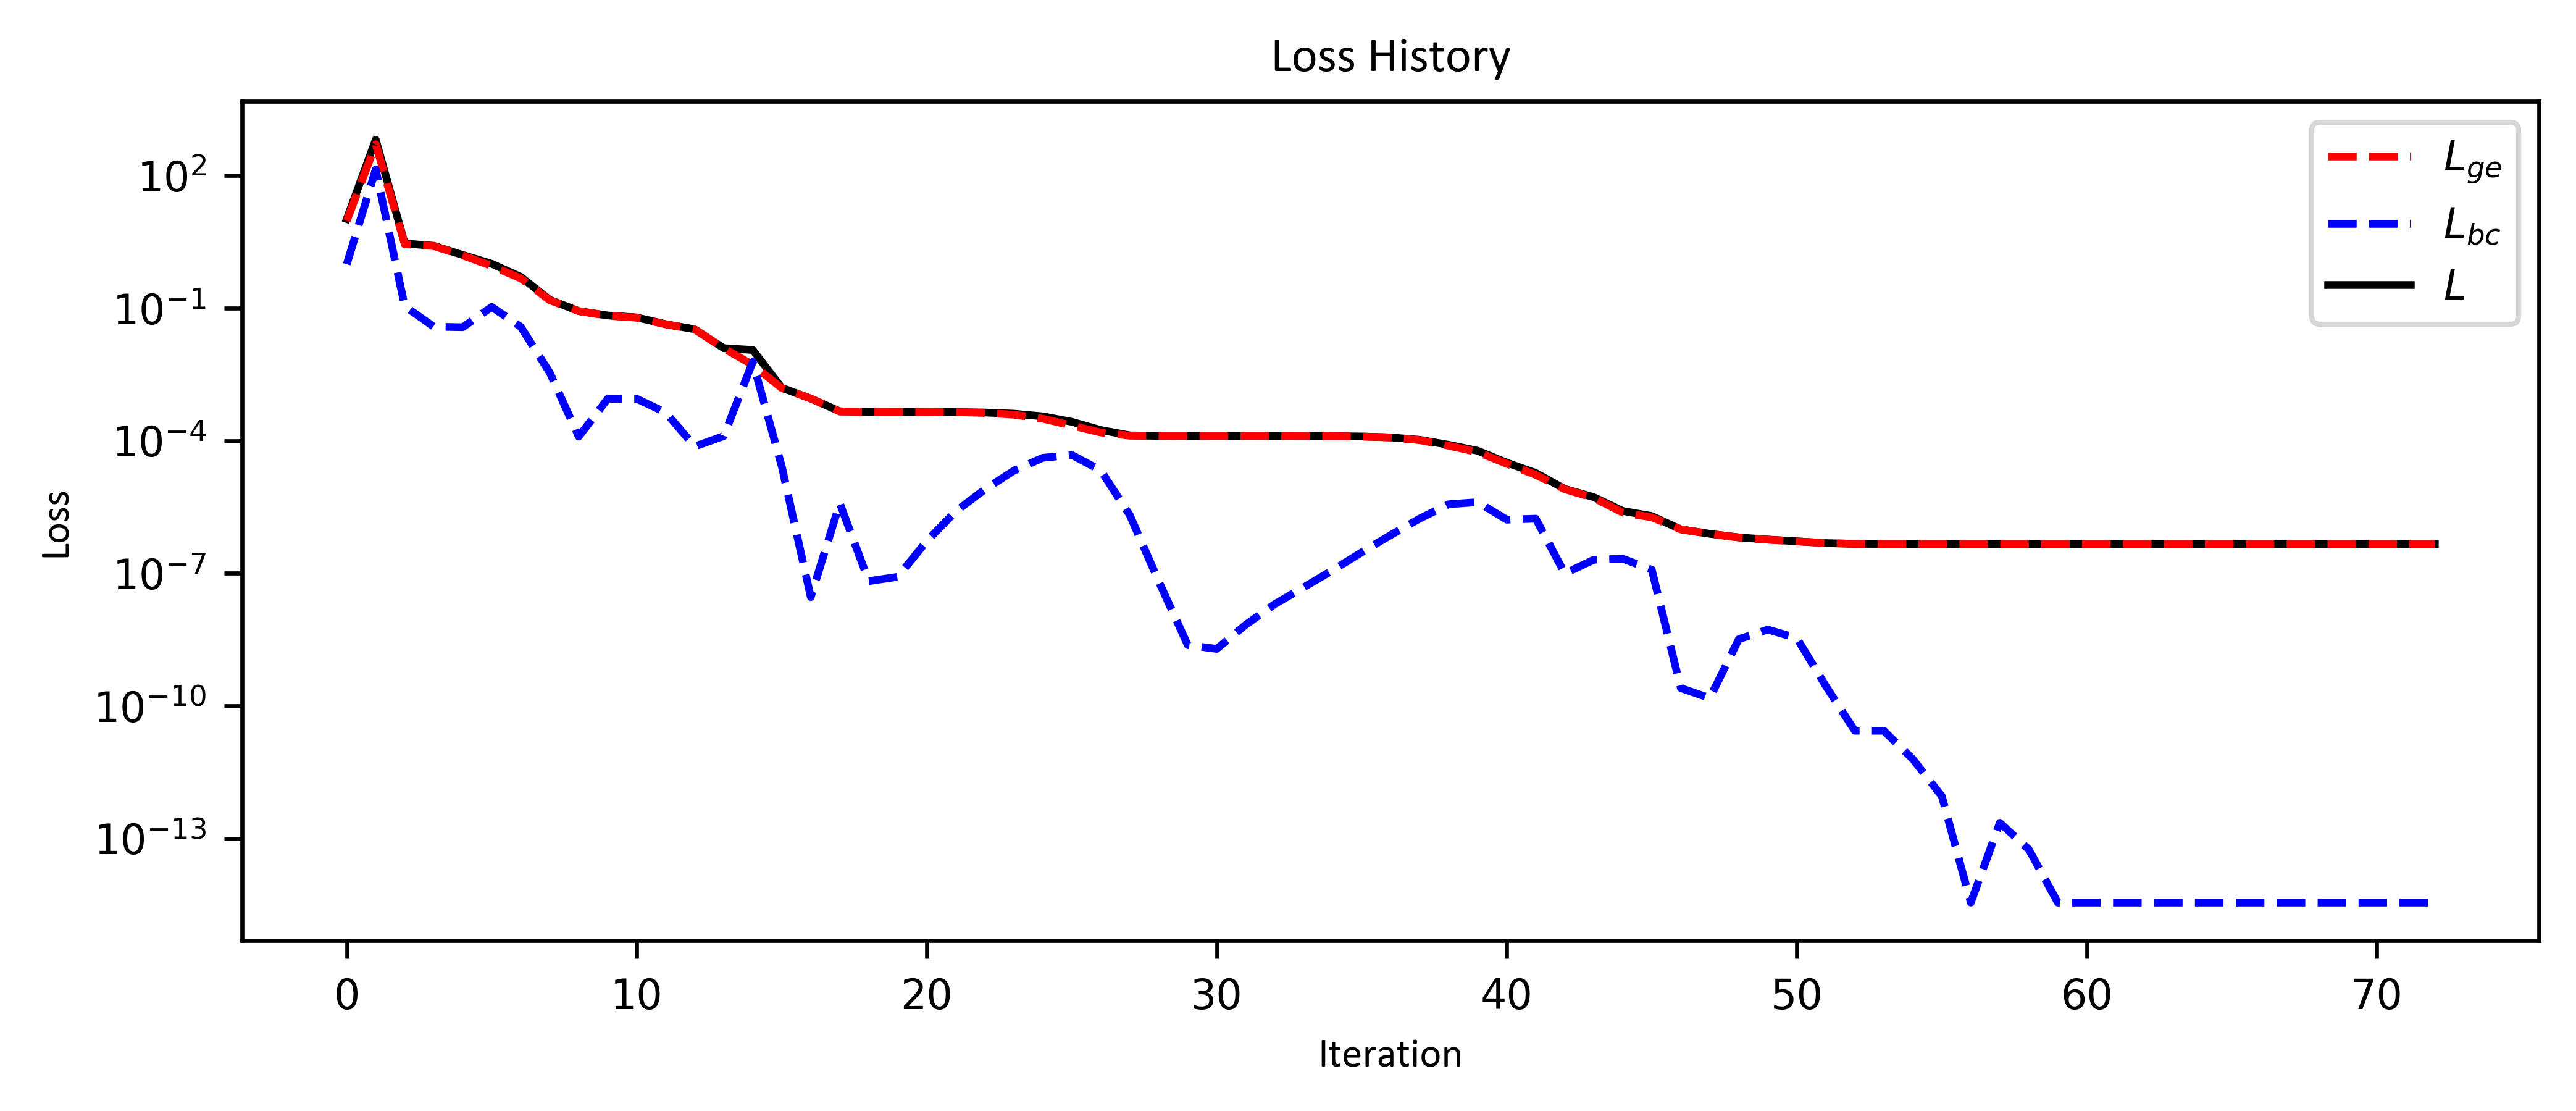

In [23]:

"""
    ====================================================================================================================

    To:
        1. Visualize the displacement, strain, and stress;
        2. Output results.

    --------------------------------------------------------------------------------------------------------------------

    Name        Type                    Info.
    
    [xy]        [array of float]        : Coordinates of all the sample points;
    [u]         [array of float]        : Displacement;
    [sigma]     [array of float]        : Stress;
    [epsilon]   [array of float]        : Strain;
    [net_u]     [keras model]           : The trained FNN for displacement u;
    [pinn]      [Keras model]           : The Physics-Informed Neural Network;
    [his_loss]  [list]                  : History values of the loss terms.

===================================================================================================================
"""

plt.rcParams.update({'font.size': 4})
    
xy = np.zeros((51, 1)).astype(np.float32)
k = 0
for i in range(0,51):
        xy[i, 0] = i * 1/50
    
u = net_u.predict(xy) * xy
temp = pinn.predict([xy for i in range(0,2)])
sigma = temp[1]
epsilon = temp[3]
    
# plot figure for displacement u
fig1 = plt.figure(1, figsize=(2,2), dpi = 600)
plt.plot(np.array([0,1]),np.array([0,0.1]), color = '#0072BD',zorder = 1)
plt.scatter(xy, u, s=10, c='#D95319',zorder = 2)
plt.xlabel('$\it{x}$ (m)', fontdict = {'fontname': 'Calibri'})
plt.ylabel('$\it{U}$ (m)', fontdict = {'fontname': 'Calibri'})
# plt.title('Displacment', fontdict = {'fontname': 'Calibri'})
plt.legend(['Analytic', 'PINN'])
# plt.axis('equal')
plt.xlim([0, 1])
plt.ylim([0, 0.1])
plt.savefig('u.tiff', dpi = 600, bbox_inches = 'tight')
plt.show()
    
# plot figure for strain epsilon
fig2 = plt.figure(2, figsize=(2,2), dpi = 600)
plt.plot(np.array([0,1]),np.array([0.1,0.1]), color = '#0072BD',zorder = 1)
plt.scatter(xy, epsilon, s = 10, c = '#D95319',zorder = 2)
plt.xlabel('$\it{x}$ (m)', fontdict = {'fontname': 'Calibri'})
plt.ylabel('$\it{\epsilon}$', fontdict = {'fontname': 'Calibri'})
# plt.title('Strain', fontdict = {'fontname': 'Calibri'})
plt.legend(['Analytic', 'PINN'])
# plt.axis('equal')
plt.xlim([0, 1])
plt.ylim([0.05, .15])
plt.savefig('epsilon.tiff', dpi = 600, bbox_inches = 'tight')
plt.show()
    
# plot figure for stress sigma
fig3 = plt.figure(3, figsize=(2,2), dpi = 600)
plt.plot(np.array([0,1]),np.array([1,1]), color = '#0072BD',zorder = 1)
plt.scatter(xy, sigma, s = 10, c = '#D95319',zorder = 2)
plt.xlabel('$\it{x}$ (m)', fontdict = {'fontname': 'Calibri'})
plt.ylabel('$\it{\sigma}$ $(N/m^2)$', fontdict = {'fontname': 'Calibri'})
# plt.title('Stress', fontdict = {'fontname': 'Calibri'})
plt.legend(['Analytic', 'PINN'])
plt.axis('equal')
plt.xlim([0, 1])
plt.ylim([0.5, 1.5])
plt.savefig('sigma.tiff', dpi = 600, bbox_inches = 'tight')
plt.show()
    
plt.rcParams.update({'font.size': 8})    

# plot figure for hist_loss
fig4 = plt.figure(4, figsize=(8,3), dpi = 600)
plt.plot(his_loss[0], color = 'r',zorder = 2,linestyle = '--')
plt.plot(his_loss[1], color = 'b',zorder = 3,linestyle = '--')
plt.plot(his_loss[0] + his_loss[1], color = 'k',zorder = 1)
plt.yscale('log')
plt.xlabel('Iteration', fontdict = {'fontname': 'Calibri'})
plt.ylabel('Loss', fontdict = {'fontname': 'Calibri'})
plt.title('Loss History', fontdict = {'fontname': 'Calibri'})
plt.legend(['$L_{ge}$', '$L_{bc}$', '$L$'])
plt.savefig('hist_loss.tiff', dpi = 600, bbox_inches = 'tight')
plt.show()
    
# output data in the 'out.mat' file
scipy.io.savemat('out.mat', {'xy': xy, 'u': u, 'sigma': sigma, 'epsilon': epsilon})